<a href="https://colab.research.google.com/github/LysanetsAndriy/Sentiment-Analysis-on-Movie-Reviews/blob/main/Sentiment_Analysis_on_Movie_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andrewlysanets","key":"6e2ede04f9c8489ba9d73e57ed28ea8a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
abdulmalik1518/mobiles-dataset-2025                               Mobiles Dataset (2025)                             20KB  2025-02-18 06:50:24           9680        175  1.0              
atharvasoundankar/chocolate-sales                                 Chocolate Sales Data 📊🍫                            63KB  2025-03-07 05:44:03           2749         36  1.0              
ignacioazua/life-expectancy                                       Life Expectancy                                     3KB  2025-03-04 06:16:35           1157         27  1.0              
mahmoudelhemaly/students-grading-dataset                    

# Donwload Kaggle dataset for Sentiment Analysis on Movie Reviews

In [ ]:
! kaggle competitions download -c 'sentiment-analysis-on-movie-reviews'

  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 159MB/s]


In [ ]:
! mkdir data

In [ ]:
! unzip sentiment-analysis-on-movie-reviews.zip -d data

Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.tsv.zip       
  inflating: data/train.tsv.zip      


In [ ]:
! mkdir data/train
! mkdir data/test

In [ ]:
! unzip data/train.tsv.zip -d data/train
! unzip data/test.tsv.zip -d data/test

Archive:  data/train.tsv.zip
  inflating: data/train/train.tsv    
Archive:  data/test.tsv.zip
  inflating: data/test/test.tsv      


# Import packages

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any
import re
import zipfile
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import nn
from torch import optim
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Configs

In [ ]:
class Config:
  #path
  train_path = 'data/train/train.tsv'
  test_path = 'data/test/test.tsv'
  look_up_id_path = 'data/IdLookupTable.csv'

  #data
  logdir = 'logdir'
  num_labels = 5
  validation_fraction = 0.3
  batch_size = 4096
  clip_value = 3

  #model
  embedding_dim=300
  hidden_size=512
  num_layers=3
  num_classes=5
  drop_prob=0.7
  pad_idx=0
  bidirectional=True

  num_epochs = 75
  seed = 42
  learning_rate = 2e-4
  weight_decay = 1e-2
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# Analyze data

In [ ]:
train = pd.read_csv(Config.train_path, sep='\t')
test = pd.read_csv(Config.test_path, sep='\t')

In [ ]:
test.tail()

,PhraseId,SentenceId,Phrase
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded
66291,222352,11855,predictable scenario


In [ ]:
train = train.dropna()
test = test.fillna('.')

In [ ]:
test.tail()

,PhraseId,SentenceId,Phrase
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded
66291,222352,11855,predictable scenario


In [ ]:
print(train.keys())
print(test.keys())

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')
Index(['PhraseId', 'SentenceId', 'Phrase'], dtype='object')


In [ ]:
print(train.shape)

(156060, 4)


In [ ]:
def clean_text(text: str) -> str:
  text = text.lower()
  text = re.sub(r"[^a-z0-9\s]", "", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

In [ ]:
def tokenize(text):
  tokens = text.split()
  return tokens if tokens else ["<UNK>"]

In [ ]:
def build_vocab(tokenized_text: List[List[str]], min_freq: int = 1) -> Dict[str, int]:
  """
  Builds a vocabulary dictionary mapping each unique token to an index.

  Special tokens:
      <PAD>: Used for padding sequences.
      <UNK>: Used for tokens not present in the vocabulary.

  Args:
      tokenized_texts (List[List[str]]): A list of tokenized texts (each text is a list of tokens).
      min_freq (int): Minimum frequency for a token to be included in the vocabulary.

  Returns:
      Dict[str, int]: A dictionary mapping tokens to unique integer indices.
  """
  vocab = {'<PAD>': 0, '<UNK>': 1}

  token_counter = Counter(token for tokens in tokenized_text for token in tokens)

  for token, freq in token_counter.items():
    if freq >= min_freq:
      if token not in vocab:
        vocab[token] = len(vocab)

  return vocab


In [ ]:
def text_to_sequence(tokens: List[str], vocab: Dict[str, int]) -> List[int]:
  """
  Converts a list of tokens to a list of integer indices using the provided vocabulary.
  Tokens not found in the vocabulary are replaced with the index of the <UNK> token.

  Args:
      tokens (List[str]): A list of tokens from a phrase.
      vocab (Dict[str, int]): A dictionary mapping tokens to their corresponding indices.

  Returns:
      List[int]: A list of integer indices representing the tokenized phrase.
  """
  unk_index = vocab.get('<UNK>')

  sequence = [vocab.get(token, unk_index) for token in tokens]

  return sequence

In [ ]:
def create_collate_fn_train(pad_idx: int):
  """
  Creates a collate function that pads sequences and tracks their original lengths.

  Each sample in the batch should be a dictionary with at least the following keys:
    - 'sequence': List[int] representing the tokenized phrase as a list of indices.
    - 'label': int representing the sentiment label.

  The collate function will:
    1. Convert the 'sequence' list into a tensor.
    2. Compute the original length of each sequence.
    3. Sort the batch in descending order by sequence length.
    4. Pad all sequences in the batch using the provided <PAD> token index.

  Args:
      pad_idx (int): The index used for padding (typically vocab['<PAD>']).

  Returns:
      A collate function that can be passed to DataLoader.
  """
  def collate_fn(batch: List[Dict[str, Any]]):
    sequences = [torch.tensor(sample['sequence'], dtype=torch.long) for sample in batch]
    labels = [sample['label'] for sample in batch]
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)

    # lengths = torch.clamp(lengths, min=1)

    sorted_indices = lengths.argsort(descending=True)
    sequences = [sequences[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]
    lengths = [lengths[i] for i in sorted_indices]

    padded_sequnce = pad_sequence(sequences=sequences, batch_first=True,
                                  padding_value=pad_idx)

    return padded_sequnce, lengths, torch.tensor(labels, dtype=torch.long)

  return collate_fn


In [ ]:
def create_collate_fn_test(pad_idx: int):
  """
  Creates a collate function that pads sequences and tracks their original lengths.

  Each sample in the batch should be a dictionary with at least the following keys:
    - 'sequence': List[int] representing the tokenized phrase as a list of indices.

  The collate function will:
    1. Convert the 'sequence' list into a tensor.
    2. Compute the original length of each sequence.
    3. Sort the batch in descending order by sequence length.
    4. Pad all sequences in the batch using the provided <PAD> token index.

  Args:
      pad_idx (int): The index used for padding (typically vocab['<PAD>']).

  Returns:
      A collate function that can be passed to DataLoader.
  """
  def collate_fn(batch: List[Dict[str, Any]]):
    sequences = [torch.tensor(sample['sequence'], dtype=torch.long) for sample in batch]
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    phrase_ids = [torch.tensor(sample['phrase_id'], dtype=torch.long) for sample in batch]

    sorted_indices = lengths.argsort(descending=True)
    sequences = [sequences[i] for i in sorted_indices]
    lengths = [lengths[i] for i in sorted_indices]
    phrase_ids = [phrase_ids[i].tolist() for i in sorted_indices]

    padded_sequnce = pad_sequence(sequences=sequences, batch_first=True,
                                  padding_value=pad_idx)

    return padded_sequnce, lengths, phrase_ids

  return collate_fn


# Create padded dataset

In [ ]:
train_phrases = np.array(train.Phrase)
test_phrases = np.array(test.Phrase)

print(test_phrases.shape)

(66292,)


In [ ]:
cleaned_train_phrases = np.array([clean_text(phrase) for phrase in train_phrases])
cleaned_test_phrases = np.array([clean_text(phrase) for phrase in test_phrases])

tokenized_train_text = [tokenize(cleaned_phrase) for cleaned_phrase in cleaned_train_phrases]
tokenized_test_text = [tokenize(cleaned_phrase) for cleaned_phrase in cleaned_test_phrases]

vocab = build_vocab(tokenized_train_text)

sequence_train_text = [text_to_sequence(tokens, vocab) for tokens in tokenized_train_text]
sequence_test_text = [text_to_sequence(tokens, vocab) for tokens in tokenized_test_text]

train_phrases_sequence = [{"sequence": sequence_train_text[i], "label": train.Sentiment.iloc[i]} for i in range(len(sequence_train_text))]
test_phrases_sequence = [{"sequence": sequence_test_text[i], "phrase_id": test.PhraseId.iloc[i]} for i in range(len(sequence_test_text))]

train_phrases_sequence = [item for item in train_phrases_sequence if len(item['sequence']) > 0]
test_phrases_sequence = [item for item in test_phrases_sequence if len(item['sequence']) > 0]

pad_idx = 0
collate_fn_train = create_collate_fn_train(pad_idx)
collate_fn_test = create_collate_fn_test(pad_idx)
padded_sequences, lengths, labels = collate_fn_train(train_phrases_sequence)
padded_sequences, lengths, phrase_ids = collate_fn_test(test_phrases_sequence)

# Dataset and Dataloader

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, phrases_sequence):
        """
        Args:
            phrases_sequence (List[Dict]): List of dictionaries, where each dictionary
                                           has at least a 'sequence' key and optionally a 'label' key.
        """
        self.phrases_sequence = phrases_sequence

    def __len__(self):
        return len(self.phrases_sequence)

    def __getitem__(self, index):
        return self.phrases_sequence[index]

In [ ]:
train_sequences, val_sequences = train_test_split(train_phrases_sequence,
                                                 test_size=Config.validation_fraction,
                                                 random_state=Config.seed)

In [ ]:
train_dataset = SentimentDataset(train_sequences)
val_dataset = SentimentDataset(val_sequences)

test_dataset = SentimentDataset(test_phrases_sequence)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, collate_fn=collate_fn_train)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=collate_fn_train)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=collate_fn_test)

In [ ]:
print("==========================")
for batch in train_loader:
    padded_sequences, lengths, labels = batch
    print("Batch padded sequences shape:", padded_sequences.shape)
    print("Batch sequence lengths:", lengths)
    print("Batch labels:", labels)
    break
print("==========================")
for batch in val_loader:
    padded_sequences, lengths, labels = batch
    print("Validation batch padded sequences shape:", padded_sequences.shape)
    print("Validation batch sequence lengths:", lengths)
    print("Validation batch labels:", labels)
    break
print("==========================")
for batch in test_loader:
    padded_sequences, lengths, phrase_ids = batch
    print("Test batch padded sequences shape:", padded_sequences.shape)
    print("Test batch sequence lengths:", lengths)
    print("Test batch phrase id:", phrase_ids)
    break
print("==========================")

Batch padded sequences shape: torch.Size([4096, 46])
Batch sequence lengths: [tensor(46), tensor(41), tensor(41), tensor(40), tensor(38), tensor(38), tensor(38), tensor(38), tensor(38), tensor(37), tensor(37), tensor(36), tensor(35), tensor(35), tensor(35), tensor(34), tensor(34), tensor(34), tensor(34), tensor(33), tensor(33), tensor(33), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(29), tensor(29), tensor(29), tensor(29), tensor(29), tensor(29), tensor(29), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27), tensor(27)

# Model class

In [ ]:
def load_glove_embeddings(glove_path, vocab, embedding_dim):
    """
    Loads GloVe embeddings from a file and creates an embedding matrix
    for the given vocabulary.

    Args:
        glove_path (str): Path to GloVe .txt file (e.g., "glove.6B.300d.txt").
        vocab (Dict[str, int]): A mapping of token -> index.
        embedding_dim (int): Dimension of the pretrained embeddings.

    Returns:
        np.ndarray: Embedding matrix of shape (len(vocab), embedding_dim).
    """
    # Initialize random embedding matrix
    embedding_matrix = np.random.uniform(
        low=-0.05, high=0.05, size=(len(vocab), embedding_dim)
    ).astype(np.float32)

    # Read the GloVe file
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = values[1:]
            if word in vocab:  # if the word is in our vocabulary
                idx = vocab[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)

    return embedding_matrix

In [ ]:
class SentimentModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes,
               drop_prob, pad_idx, bidirectional=True, pretrained_embeddings=None,
               freeze_embeddings=False):
    """
    Initializes the SentimentModel model.

    Args:
        vocab_size (int): Number of words in the vocabulary.
        embedding_dim (int): Dimensionality of the word embeddings.
        hidden_size (int): Number of features in the hidden state of the LSTM.
        num_layers (int): Number of recurrent layers.
        num_classes (int): Number of sentiment classes.
        drop_prob (float): Dropout probability.
        pad_idx (int): Index used for padding.
        bidirectional (bool): Whether to use a bidirectional LSTM.
    """
    super(SentimentModel, self).__init__()

    self.pad_idx = pad_idx
    self.bidirectional = bidirectional

    if pretrained_embeddings is not None:
        self.embedding = nn.Embedding.from_pretrained(
            embeddings=torch.tensor(pretrained_embeddings),
            freeze=freeze_embeddings,
            padding_idx=pad_idx
        )
    else:
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=pad_idx
        )

    self.lstm = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=drop_prob,
        bidirectional=self.bidirectional
    )

    fc_in_features = hidden_size * 2 if bidirectional else hidden_size

    self.batch_norm = nn.BatchNorm1d(fc_in_features)
    self.dropout = nn.Dropout(p=drop_prob)
    self.fc = nn.Linear(fc_in_features, out_features=num_classes)

  def forward(self, x, lengths):
    """
    Forward pass for the model.

    Args:
        x (torch.Tensor): Tensor of token indices of shape (batch, seq_length).

    Returns:
        torch.Tensor: Logits of shape (batch, num_classes).
    """
    lengths = lengths.cpu()

    embedded = self.embedding(x)

    packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True,
                                           enforce_sorted=False)

    packed_output, (h_n, c_n) = self.lstm(packed_embedded)

    if self.bidirectional:
      h_last = torch.cat((h_n[-2], h_n[-1]), dim=1)
    else:
      h_last = h_n[-1]

    out = self.batch_norm(h_last)
    out = self.dropout(out)
    out = self.fc(out)

    return out

In [ ]:
# with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
#     zip_ref.extractall('./')

In [ ]:
# vocab_size = 10000   # size of your vocabulary
# embedding_dim = 300
# hidden_size = 256
# num_layers = 2
# num_classes = 5      # sentiment classes: 0-4
# drop_prob = 0.5
# pad_idx = 0
# bidirectional = True

# glove_path = "glove.6B.300d.txt"
# pretrained_matrix = load_glove_embeddings(glove_path, vocab, embedding_dim)

# # Create the model instance
# model = SentimentModel(vocab_size, embedding_dim, hidden_size, num_layers,
#                        num_classes, drop_prob, pad_idx, bidirectional,
#                        pretrained_embeddings=pretrained_matrix)

# # Dummy input: a batch of 3 sequences of token indices (padded)
# test_input = torch.tensor([
#     [1, 5, 234, 6543, 2, 0, 0],
#     [1, 6, 234, 2, 0, 0, 0],
#     [1, 7, 2, 0, 0, 0, 0]
# ], dtype=torch.long)

# test_lengths = torch.tensor(
#     [5, 4, 3]
#     )

# # Forward pass
# logits = model(test_input, test_lengths)
# print("Logits shape:", logits.shape)

# Train and Eval loop

In [ ]:
def train_loop(model, optimizer, criterion, train_loader, clip_value, device):
    running_loss = 0
    model.train()

    pbar = tqdm(train_loader, desc='Train')

    for seq, lengths, targets in pbar:
        # pass to device
        seq = seq.to(device)
        lengths = torch.from_numpy(np.array(lengths))
        lengths = lengths.to(device)
        targets = targets.to(device)
        # forward
        out = model(seq, lengths)
        loss = criterion(out, targets)
        running_loss += loss.item()*seq.shape[0]
        # optimize & clip
        optimizer.zero_grad()
        loss.backward()

        if clip_value:
          nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

    running_loss /= len(train_loader.sampler)
    return running_loss

In [ ]:
def eval_loop(model, criterion, eval_loader, device, ignore_index=None):
    running_loss = 0
    model.eval()

    pbar = tqdm(eval_loader, desc='Eval')

    with torch.no_grad():
        accuracy, f1_scores = [], []
        for seq, lengths, targets in pbar:
            # pass to device
            seq = seq.to(device)
            lengths = torch.from_numpy(np.array(lengths))
            lengths = lengths.to(device)
            targets = targets.to(device)
            # forward
            out = model(seq, lengths)
            loss = criterion(out, targets)
            running_loss += loss.item()*seq.shape[0]
            # calculate prediction
            predicted = torch.argmax(out, dim=1)
            predicted = predicted.cpu().numpy()
            labels = targets.cpu().numpy()

            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted, average='macro'))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {'accuracy':acc,
            'f1_macro':f1,
            'loss':running_loss}

In [ ]:
def train_model(model, optimizer, criterion, train_loader, valid_loader,
          num_epochs, clip_value, device=Config.device, valid_loss_min=np.inf,
          log_file="training_log.txt"):
  """
  Trains the model and evaluates it on the validation set every 'eval_every' epochs.
  Logs metrics to a text file.

  Args:
      model (nn.Module): The model to train.
      optimizer (torch.optim.Optimizer): The optimizer.
      criterion (nn.Module): The loss function.
      train_loader (DataLoader): DataLoader for training data.
      valid_loader (DataLoader): DataLoader for validation data.
      eval_every (int): How often to evaluate (in epochs).
      num_epochs (int): Total number of epochs to train.
      clip_value (float): Gradient clipping value.
      device (torch.device): Device on which to train.
      valid_loss_min (float): Best validation loss so far.
      log_file (str): File path to save training logs.

  Returns:
      float: The best validation loss achieved.
  """

  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

  with open(log_file, "w") as log_f:
    log_f.write("Training started\n")

  epochs_without_improvement = 0

  for epoch in range(num_epochs):
    train_loss = train_loop(model, optimizer, criterion, train_loader, clip_value, device)

    metrics = eval_loop(model, criterion, valid_loader, device)
    log_string = (f"Epoch: {epoch+1} | "
                  f"Train Loss: {train_loss:.5f} | "
                  f"Valid Loss: {metrics['loss']:.5f} | "
                  f"Accuracy: {metrics['accuracy']:.5f} | "
                  f"F1 Macro: {metrics['f1_macro']:.3f}")
    print(log_string)
    with open(log_file, "a") as log_f:
        log_f.write(log_string + "\n")

    # Save model if validation loss decreases
    if metrics["loss"] < valid_loss_min:
        torch.save(model.state_dict(), "best_model.pt")
        valid_loss_min = metrics["loss"]
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1

  return valid_loss_min

# Train

In [ ]:
set_seed(Config.seed)

glove_path = "glove.6B.300d.txt"
pretrained_matrix = load_glove_embeddings(glove_path, vocab, Config.embedding_dim)

model = SentimentModel(
    vocab_size=len(vocab),
    embedding_dim=Config.embedding_dim,
    hidden_size=Config.hidden_size,
    num_layers=Config.num_layers,
    num_classes=Config.num_classes,
    drop_prob=Config.drop_prob,
    pad_idx=Config.pad_idx,
    bidirectional=Config.bidirectional,
    pretrained_embeddings=pretrained_matrix
)

model = model.to(Config.device)
optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate,
                        weight_decay=Config.weight_decay)
criterion = nn.CrossEntropyLoss()

valid_loss_min = train_model(model, optimizer, criterion, train_loader, val_loader,
                       num_epochs=Config.num_epochs, clip_value=Config.clip_value,
                       device=Config.device)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Eval: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Epoch: 1 | Train Loss: 1.62915 | Valid Loss: 1.54406 | Accuracy: 0.57861 | F1 Macro: 0.330


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch: 2 | Train Loss: 1.42515 | Valid Loss: 1.42074 | Accuracy: 0.58791 | F1 Macro: 0.368


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch: 3 | Train Loss: 1.33396 | Valid Loss: 1.22437 | Accuracy: 0.59547 | F1 Macro: 0.433


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


Epoch: 4 | Train Loss: 1.23879 | Valid Loss: 1.18498 | Accuracy: 0.60561 | F1 Macro: 0.419


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch: 5 | Train Loss: 1.11877 | Valid Loss: 1.06514 | Accuracy: 0.61282 | F1 Macro: 0.414


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch: 6 | Train Loss: 1.05359 | Valid Loss: 1.04979 | Accuracy: 0.61748 | F1 Macro: 0.433


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch: 7 | Train Loss: 1.01666 | Valid Loss: 1.04190 | Accuracy: 0.62135 | F1 Macro: 0.453


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch: 8 | Train Loss: 0.99385 | Valid Loss: 0.99039 | Accuracy: 0.62339 | F1 Macro: 0.443


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch: 9 | Train Loss: 0.96801 | Valid Loss: 1.00166 | Accuracy: 0.62687 | F1 Macro: 0.441


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch: 10 | Train Loss: 0.95039 | Valid Loss: 1.05101 | Accuracy: 0.62576 | F1 Macro: 0.489


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch: 11 | Train Loss: 0.92280 | Valid Loss: 0.96220 | Accuracy: 0.63991 | F1 Macro: 0.482


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch: 12 | Train Loss: 0.89659 | Valid Loss: 0.96739 | Accuracy: 0.64308 | F1 Macro: 0.494


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch: 13 | Train Loss: 0.87220 | Valid Loss: 0.95987 | Accuracy: 0.64772 | F1 Macro: 0.502


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch: 14 | Train Loss: 0.86192 | Valid Loss: 0.94687 | Accuracy: 0.64805 | F1 Macro: 0.480


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch: 15 | Train Loss: 0.83841 | Valid Loss: 0.92321 | Accuracy: 0.65452 | F1 Macro: 0.514


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch: 16 | Train Loss: 0.81724 | Valid Loss: 0.90961 | Accuracy: 0.65681 | F1 Macro: 0.513


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch: 17 | Train Loss: 0.80187 | Valid Loss: 0.91020 | Accuracy: 0.65497 | F1 Macro: 0.496


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch: 18 | Train Loss: 0.78930 | Valid Loss: 0.92903 | Accuracy: 0.65829 | F1 Macro: 0.536


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch: 19 | Train Loss: 0.77209 | Valid Loss: 0.92049 | Accuracy: 0.66285 | F1 Macro: 0.538


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch: 20 | Train Loss: 0.75613 | Valid Loss: 0.90845 | Accuracy: 0.66712 | F1 Macro: 0.535


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch: 21 | Train Loss: 0.74406 | Valid Loss: 0.90878 | Accuracy: 0.66558 | F1 Macro: 0.532


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch: 22 | Train Loss: 0.73940 | Valid Loss: 0.90385 | Accuracy: 0.66521 | F1 Macro: 0.543


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch: 23 | Train Loss: 0.71977 | Valid Loss: 0.92924 | Accuracy: 0.66729 | F1 Macro: 0.547


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch: 24 | Train Loss: 0.71040 | Valid Loss: 0.91038 | Accuracy: 0.66842 | F1 Macro: 0.536


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch: 25 | Train Loss: 0.70437 | Valid Loss: 0.91216 | Accuracy: 0.66869 | F1 Macro: 0.559


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch: 26 | Train Loss: 0.69626 | Valid Loss: 0.91233 | Accuracy: 0.66993 | F1 Macro: 0.554


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch: 27 | Train Loss: 0.68744 | Valid Loss: 0.92517 | Accuracy: 0.66785 | F1 Macro: 0.549


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch: 28 | Train Loss: 0.67755 | Valid Loss: 0.94100 | Accuracy: 0.67013 | F1 Macro: 0.567


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


Epoch: 29 | Train Loss: 0.67018 | Valid Loss: 0.95374 | Accuracy: 0.66220 | F1 Macro: 0.518


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch: 30 | Train Loss: 0.66703 | Valid Loss: 0.94542 | Accuracy: 0.66615 | F1 Macro: 0.554


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


Epoch: 31 | Train Loss: 0.65837 | Valid Loss: 0.94303 | Accuracy: 0.66828 | F1 Macro: 0.558


Eval: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch: 32 | Train Loss: 0.64846 | Valid Loss: 0.94332 | Accuracy: 0.66859 | F1 Macro: 0.558


Train:  59%|█████▉    | 16/27 [00:12<00:09,  1.20it/s]

In [ ]:
print(valid_loss_min)

0.8716698095276924


# Plot metrics

In [ ]:
def plot_training_metrics(log_file):
    """
    Reads training logs from a file and plots Train Loss, Validation Loss, Accuracy, and F1 Macro Score.

    Args:
        log_file (str): Path to the training log file.
    """
    # Read log file and extract metrics
    epochs = []
    train_losses = []
    valid_losses = []
    accuracies = []
    f1_scores = []

    with open(log_file, "r") as file:
        for line in file:
            match = re.match(r"Epoch: (\d+) \| Train Loss: ([\d.]+) \| Valid Loss: ([\d.]+) \| Accuracy: ([\d.]+) \| F1 Macro: ([\d.]+)", line)
            if match:
                epochs.append(int(match.group(1)))
                train_losses.append(float(match.group(2)))
                valid_losses.append(float(match.group(3)))
                accuracies.append(float(match.group(4)))
                f1_scores.append(float(match.group(5)))

    # Convert to DataFrame for better visualization
    df = pd.DataFrame({
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Valid Loss": valid_losses,
        "Accuracy": accuracies,
        "F1 Macro": f1_scores
    })

    # Plot Metrics
    plt.figure(figsize=(12, 6))

    # Train Loss vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss", marker="o")
    plt.plot(df["Epoch"], df["Valid Loss"], label="Valid Loss", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train & Validation Loss")
    plt.legend()
    plt.grid()

    # Accuracy & F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(df["Epoch"], df["Accuracy"], label="Accuracy", marker="o")
    plt.plot(df["Epoch"], df["F1 Macro"], label="F1 Macro", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Accuracy & F1 Score")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

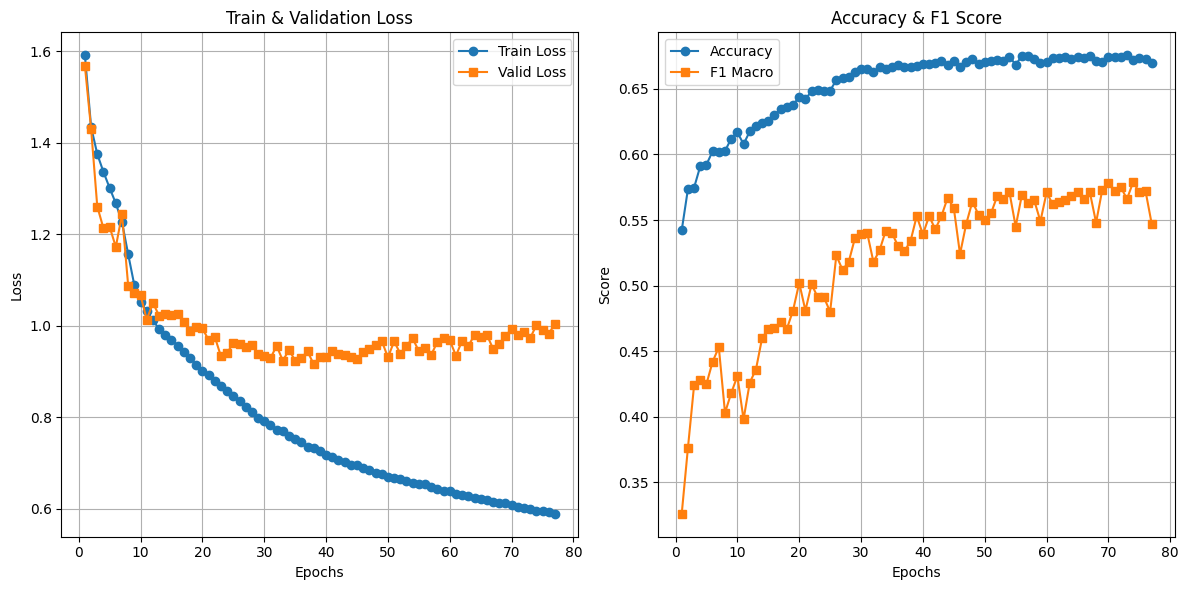

In [ ]:
log_file = "training_log.txt"  # Update this path if necessary
plot_training_metrics(log_file)

# Predict test set

In [ ]:
def predict_test_set(model, test_loader, device, output_file="submission.csv"):
    """
    Predicts sentiment labels for the test set and creates a submission CSV file.

    Args:
        model (nn.Module): Trained model for sentiment analysis.
        test_loader (DataLoader): DataLoader for the test set. Each batch should return:
                                  (padded_sequences, lengths, phrase_ids)
        device (torch.device): Device on which the model is loaded.
        output_file (str): File name for the submission CSV.

    The submission CSV will have two columns: 'PhraseId' and 'Sentiment', sorted by PhraseId.
    """
    model.eval()
    all_phrase_ids = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            # Unpack the batch; your test collate_fn should return phrase_ids along with the data.
            padded_sequences, lengths, phrase_ids = batch

            padded_sequences = padded_sequences.to(device)
            lengths = torch.from_numpy(np.array(lengths))
            lengths = lengths.to(device)

            # Forward pass: get model logits
            outputs = model(padded_sequences, lengths)
            # Choose the class with highest probability
            preds = torch.argmax(outputs, dim=1)
            # Convert predictions to list
            preds = preds.cpu().numpy().tolist()

            # Collect results
            all_predictions.extend(preds)
            all_phrase_ids.extend(phrase_ids)

    # Create a DataFrame for submission
    submission_df = pd.DataFrame({
        "PhraseId": all_phrase_ids,
        "Sentiment": all_predictions
    })

    # Sort the submission by PhraseId (if necessary)
    submission_df = submission_df.sort_values("PhraseId")

    # Write to CSV (without index)
    submission_df.to_csv(output_file, index=False)
    print(f"Submission file saved to: {output_file}")

In [ ]:
set_seed(Config.seed)

glove_path = "glove.6B.300d.txt"
pretrained_matrix = load_glove_embeddings(glove_path, vocab, Config.embedding_dim)

model = SentimentModel(
    vocab_size=len(vocab),
    embedding_dim=Config.embedding_dim,
    hidden_size=Config.hidden_size,
    num_layers=Config.num_layers,
    num_classes=Config.num_classes,
    drop_prob=Config.drop_prob,
    pad_idx=Config.pad_idx,
    bidirectional=Config.bidirectional,
    pretrained_embeddings=pretrained_matrix
)

model = model.to(Config.device)

model.load_state_dict(torch.load('best_model2.pt', map_location=Config.device))

<ipython-input-73-40892a70fe90>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model2.pt', map_location=Config.device))


<All keys matched successfully>

In [ ]:
predict_test_set(model, test_loader, device=Config.device, output_file="submission.csv")

Submission file saved to: submission.csv
